In [131]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
from sklearn.preprocessing import RobustScaler,MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
import plotly.express as px
from sklearn.decomposition import PCA
import sklearn

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

### account
- number of customer
- number of active customer (with at least 1 active account)
- feature: number of account per customer, number of active account, number of nonactive account

In [2]:
account= pd.read_csv('mini-project-III/twm_accounts.csv',sep=";")
account.head()

,acct_nbr,cust_id,acct_type,account_active,acct_start_date,acct_end_date,starting_balance,ending_balance
0,13628063,1362806,SV,Y,10.12.1995,NaN,1430.22,284.58
1,4561143213627090,1362709,CC,Y,15.3.1993,NaN,266.34,496.15
2,4561143213628360,1362836,CC,Y,18.3.1992,NaN,55.90,1000.00
3,13633112,1363311,CK,Y,6.7.1995,NaN,11017.13,968.46
4,4561143213633610,1363361,CC,Y,17.6.1994,NaN,849.37,462.28


In [3]:
## feature: number of accounts per customer
no_account= account.groupby('cust_id').acct_type.count().reset_index()
no_account.columns = ['cust_id', 'no_of_account']
no_account.head()

,cust_id,no_of_account
0,1362480,3
1,1362484,3
2,1362485,2
3,1362486,2
4,1362487,3


In [4]:
## number of customer : 665
no_account.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 665 entries, 0 to 664
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   cust_id        665 non-null    int64
 1   no_of_account  665 non-null    int64
dtypes: int64(2)
memory usage: 10.5 KB


In [5]:
## feature: number of active account per customer
no_active_account= account[account.account_active == "Y "].groupby('cust_id').acct_type.count().reset_index()
no_active_account.columns= ['cust_id', 'no_active_account']
no_active_account.info()
# 642 active customer (have at least 1 active account)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 642 entries, 0 to 641
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   cust_id            642 non-null    int64
 1   no_active_account  642 non-null    int64
dtypes: int64(2)
memory usage: 10.2 KB


In [6]:
## create new dataframe with 3 new features
account_features= no_account.merge(no_active_account,how='outer')
account_features.head()

,cust_id,no_of_account,no_active_account
0,1362480,3,2.0
1,1362484,3,3.0
2,1362485,2,2.0
3,1362486,2,2.0
4,1362487,3,2.0


In [7]:
# handling na value: no_active_account = na means 0 active account
account_features.no_active_account.fillna(0,inplace= True)

In [8]:
account_features.isna().sum()

cust_id              0
no_of_account        0
no_active_account    0
dtype: int64

In [9]:
## feature: number of non-active account per customer (unsatisfied customers, higher value means the more disatisfied )
account_features['no_nonactive_account']=account_features.no_of_account- account_features.no_active_account

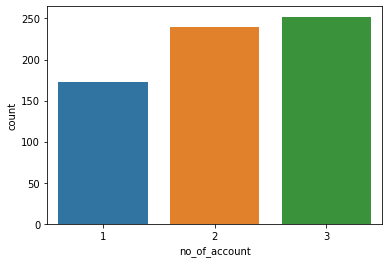

In [10]:
# data exploration
sns.countplot(data= account_features, x='no_of_account');

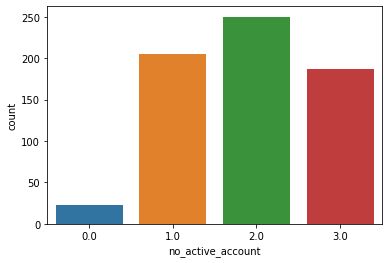

In [11]:
# data exploration
sns.countplot(data= account_features, x= 'no_active_account');
# not significant different between number of account per cust and number of active account per cust
# >>may consider to use only one feature in the model

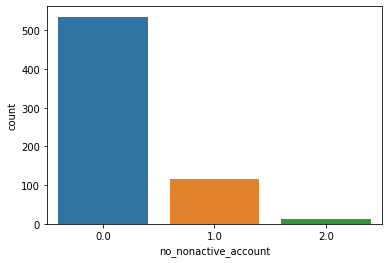

In [12]:
# data exploration
sns.countplot(data= account_features, x= 'no_nonactive_account');

### checking account
- feature: checking account_active, starting_balance, ending_balance

In [13]:
checking_account= pd.read_csv('mini-project-III/twm_checking_acct.csv',sep=";")
checking_account.head()

,cust_id,acct_nbr,minimum_balance,per_check_fee,account_active,acct_start_date,acct_end_date,starting_balance,ending_balance
0,1362548,13625482,3000,0.00,Y,11.11.1986,NaN,6004.34,569.65
1,1362487,13624872,3000,0.00,Y,12.1.1995,NaN,2781.07,1401.21
2,1363017,13630172,3000,0.00,Y,19.3.1994,NaN,2694.91,147.15
3,1362752,13627522,100,0.15,Y,8.1.1994,NaN,487.69,3.76
4,1363282,13632822,100,0.15,Y,5.3.1988,NaN,133.90,84.18


In [14]:
checking_account.groupby('cust_id').acct_nbr.count().sort_values(ascending= False)
# each cust id have 1 checking account (no duplication in the data)

cust_id
1362480    1
1363199    1
1363196    1
1363195    1
1363193    1
          ..
1362809    1
1362808    1
1362806    1
1362805    1
1363495    1
Name: acct_nbr, Length: 520, dtype: int64

account_active
N      52
Y     468
Name: acct_nbr, dtype: int64

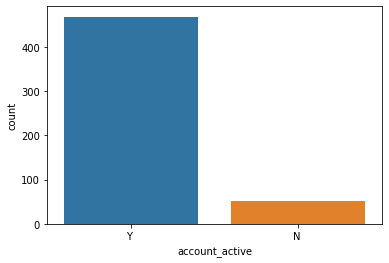

In [15]:
sns.countplot(data= checking_account, x= 'account_active');
checking_account.groupby('account_active').acct_nbr.count()

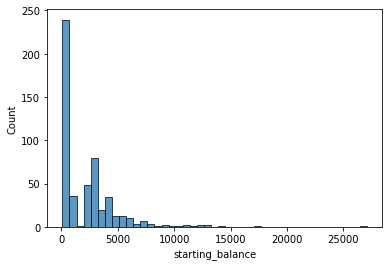

skewness: 3.044065669215468
ShapiroResult(statistic=0.7128396034240723, pvalue=6.905153389114435e-29)


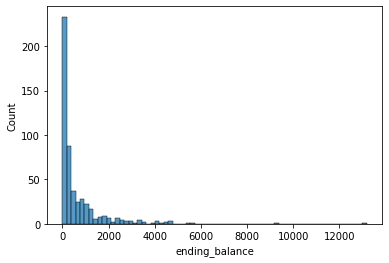

skewness: 4.652203861727065
ShapiroResult(statistic=0.5660349130630493, pvalue=6.2804491254950685e-34)


In [16]:
for a in ['starting_balance', 'ending_balance']:
    sns.histplot(checking_account[a])
    plt.show()
    print("skewness:", checking_account[a].skew())
    print(st.shapiro(checking_account[a]))

<AxesSubplot:ylabel='Count'>

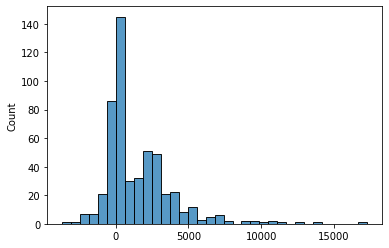

In [17]:
## checking_spending
sns.histplot(checking_account.starting_balance -checking_account.ending_balance)

In [18]:
## feature:
checking_account_features= checking_account[['cust_id','account_active','starting_balance','ending_balance']]
checking_account_features.head()

,cust_id,account_active,starting_balance,ending_balance
0,1362548,Y,6004.34,569.65
1,1362487,Y,2781.07,1401.21
2,1363017,Y,2694.91,147.15
3,1362752,Y,487.69,3.76
4,1363282,Y,133.90,84.18


In [19]:
checking_account_features.columns=['cust_id', 'checking_account_active', 'checking_starting_balance', 'checking_ending_balance']

In [20]:
checking_account_features.tail()
## starting_balanace & ending_balance seem to reflect data of one month only (not match with checking tran data)
## >> later to decide if this feature is useful or not

,cust_id,checking_account_active,checking_starting_balance,checking_ending_balance
515,1363467,Y,4155.98,58.47
516,1362855,Y,202.30,1070.87
517,1363324,Y,4010.41,2325.37
518,1362569,Y,927.07,46.48
519,1363303,Y,2789.57,39.22


### checking tran
- features: number of checking transaction (spending+ deposit), number of spending trans, avg value of checking trans, avg spending value, avg deposit value
- auto transaction made by system are small in value and volume so we wont take this features in our model (consumers have no control of these auto transaction anyway)

***understand data***

In [21]:
checking_tran= pd.read_csv('mini-project-III/twm_checking_tran.csv',sep=";")
checking_tran.head(10)

,cust_id,tran_id,tran_amt,principal_amt,interest_amt,new_balance,tran_date,tran_time,channel,tran_code
0,1363481,26,-0.15,-0.15,0.00,58.99,29.1.1995,,,FK
1,1362784,90,-200.00,-200.00,0.00,1380.69,2.7.1995,53313,A,WD
2,1363088,46,0.00,0.00,0.00,128.35,26.3.1995,834,A,IQ
3,1363306,32,-40.32,-40.32,0.00,433.06,29.1.1995,,P,WD
4,1363251,11,-87.88,-87.88,0.00,1919.55,8.2.1995,,P,WD
5,1363303,20,-58.58,-58.58,0.00,2660.59,25.2.1995,,P,WD
6,1362981,39,-311.06,-311.06,0.00,564.99,7.9.1995,160041,A,TR
7,1363216,97,-45.11,-45.11,0.00,480.60,22.1.1995,,P,WD
8,1363253,62,0.94,0.00,0.94,751.88,30.6.1995,235959,,IN
9,1363442,16,-0.75,-0.75,0.00,4776.26,15.1.1995,115613,,FU


In [22]:
checking_tran[checking_tran.interest_amt != 0]
## transaction with principal_amt ==0 is interest rate, auto transaction by system only

,cust_id,tran_id,tran_amt,principal_amt,interest_amt,new_balance,tran_date,tran_time,channel,tran_code
8,1363253,62,0.94,0.0,0.94,751.88,30.6.1995,235959,,IN
31,1363168,55,2.40,0.0,2.40,1636.33,31.3.1995,235959,,IN
40,1362905,2,3.38,0.0,3.38,2705.01,31.1.1995,235959,,IN
66,1363235,86,0.49,0.0,0.49,391.51,28.2.1995,235959,,IN
137,1363462,8,3.90,0.0,3.90,2476.61,30.4.1995,235959,,IN
...,...,...,...,...,...,...,...,...,...,...
46039,1362594,41,14.30,0.0,14.30,11450.48,30.6.1995,235959,,IN
46102,1362768,2,3.13,0.0,3.13,2505.93,31.1.1995,235959,,IN
46109,1363323,52,14.40,0.0,14.40,11536.54,31.5.1995,235959,,IN
46113,1363109,47,1.17,0.0,1.17,938.97,31.1.1995,235959,,IN


In [23]:
checking_tran.describe().round(1)
# auto transaction (interest_amt) is small in value, these transaction are made by the system, not customers >> may not be a useful features
# principal_amt are transaction made by customer, wide range of value b/t min & max 
#>> mean value may not reflect the spending of customer because it is offset by the positive deposit

,cust_id,tran_id,tran_amt,principal_amt,interest_amt,new_balance
count,46204.0,46204.0,46204.0,46204.0,46204.0,46204.0
mean,1362998.1,47.8,-17.0,-17.2,0.1,1152.2
std,295.7,28.5,246.4,246.4,0.8,2009.3
min,1362480.0,1.0,-3312.4,-3312.4,0.0,0.0
25%,1362740.0,23.0,-80.0,-80.0,0.0,78.4
50%,1362997.0,47.0,-0.8,-0.8,0.0,407.5
75%,1363262.0,72.0,0.0,0.0,0.0,1522.7
max,1363495.0,99.0,5355.0,5355.0,27.3,29868.4


***features: transaction made by customers***

In [24]:
## feature: number of checking transaction MADE by customer (spending + deposit)
number_checking_tran= checking_tran[checking_tran.principal_amt != 0].groupby('cust_id').tran_id.count().reset_index()
number_checking_tran.columns= ['cust_id','number_checking_tran']
number_checking_tran.head()

,cust_id,number_checking_tran
0,1362480,83
1,1362484,85
2,1362485,83
3,1362486,10
4,1362487,34


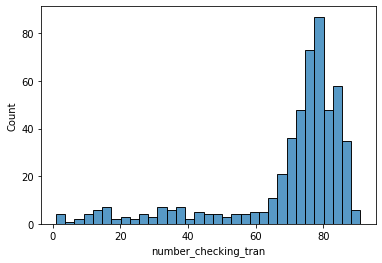

In [25]:
## feature exploration
sns.histplot(data= number_checking_tran, x= 'number_checking_tran');

In [26]:
## feature: number of spending transaction MADE by customer
number_checking_spending= checking_tran[checking_tran.principal_amt < 0].groupby('cust_id').tran_id.count().reset_index()
number_checking_spending.columns= ['cust_id','number_checking_spending']
number_checking_spending.head()

,cust_id,number_checking_spending
0,1362480,69
1,1362484,72
2,1362485,67
3,1362486,9
4,1362487,32


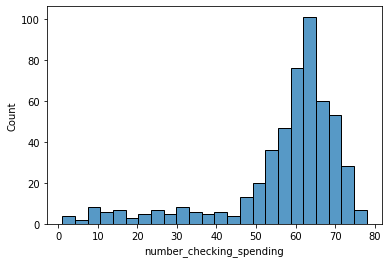

In [27]:
## feature exploration
sns.histplot(data= number_checking_spending, x= 'number_checking_spending');

In [28]:
## feature: average value per transaction made by customers
value_checking_tran= checking_tran[checking_tran.principal_amt != 0].groupby('cust_id').tran_amt.mean().reset_index()
value_checking_tran.columns= ['cust_id','value_checking_tran']
value_checking_tran.sort_values('value_checking_tran', ascending= False).head()

,cust_id,value_checking_tran
111,1362700,143.086667
276,1363022,72.715000
431,1363326,51.159487
236,1362959,43.769167
9,1362500,36.749375


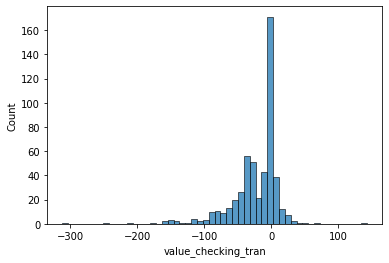

In [29]:
## feature exploration
sns.histplot(data= value_checking_tran, x= 'value_checking_tran');
# A lot of data center around 0, again, mean value may not reflect the average spending value (spending power) of customers 

In [30]:
## feature: total value per transaction made by customers
totalvalue_checking_tran= checking_tran[checking_tran.principal_amt != 0].groupby('cust_id').tran_amt.sum().reset_index()
totalvalue_checking_tran.columns= ['cust_id','totalvalue_checking_tran']
totalvalue_checking_tran.sort_values('totalvalue_checking_tran', ascending= False).head()

,cust_id,totalvalue_checking_tran
236,1362959,3676.61
428,1363321,2539.24
164,1362806,2342.77
299,1363083,2038.95
442,1363345,2032.35


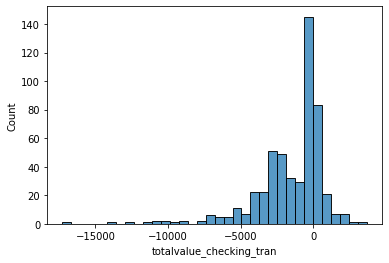

In [31]:
sns.histplot(data= totalvalue_checking_tran, x= 'totalvalue_checking_tran');

In [32]:
## feature: average value per SPENDING transaction 
value_checking_spending= checking_tran[checking_tran.principal_amt < 0].groupby('cust_id').tran_amt.mean().reset_index()
value_checking_spending.columns= ['cust_id','value_checking_spending']
value_checking_spending.sort_values('value_checking_spending', ascending= False).head()

,cust_id,value_checking_spending
312,1363108,-0.750000
67,1362611,-0.750000
421,1363308,-0.750000
233,1362950,-0.750000
133,1362742,-7.279412


In [33]:
# convert to positive number
value_checking_spending.value_checking_spending= abs(value_checking_spending.value_checking_spending)

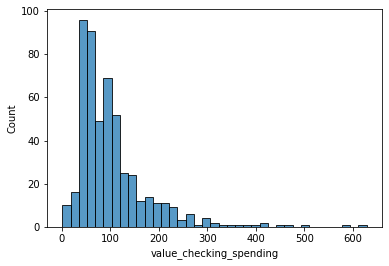

In [34]:
## feature exploration
sns.histplot(data= value_checking_spending, x= 'value_checking_spending');

In [35]:
## feature: average value per deposit transaction 
value_checking_deposit= checking_tran[checking_tran.principal_amt > 0].groupby('cust_id').tran_amt.mean().reset_index()
value_checking_deposit.columns= ['cust_id','value_checking_deposit']
value_checking_deposit.sort_values('value_checking_deposit', ascending= False).head()

,cust_id,value_checking_deposit
506,1363492,2005.706667
169,1362820,1434.821176
9,1362500,1413.275000
492,1363457,1390.324545
231,1362959,1304.853571


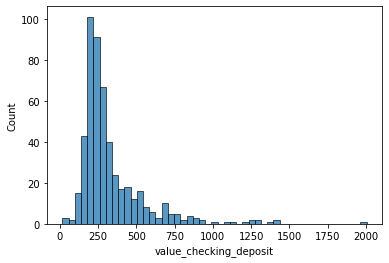

In [36]:
## feature exploration
sns.histplot(data= value_checking_deposit, x= 'value_checking_deposit');

***create a dataframe of all features***

In [37]:
checking_tran_features= number_checking_tran.merge(number_checking_spending, how='outer').merge(value_checking_tran,how='outer').merge(totalvalue_checking_tran,how='outer').merge(value_checking_spending,how='outer').merge(
value_checking_deposit, how='outer'    
)

In [38]:
checking_tran_features.isna().sum()

cust_id                     0
number_checking_tran        0
number_checking_spending    0
value_checking_tran         0
totalvalue_checking_tran    0
value_checking_spending     0
value_checking_deposit      8
dtype: int64

In [39]:
checking_tran_features[checking_tran_features.value_checking_deposit.isna()]
# customer who never deposit money (deposit =0 )

,cust_id,number_checking_tran,number_checking_spending,value_checking_tran,totalvalue_checking_tran,value_checking_spending,value_checking_deposit
67,1362611,2,2,-0.750000,-1.50,0.750000,NaN
128,1362734,2,2,-10.000000,-20.00,10.000000,NaN
133,1362742,17,17,-7.279412,-123.75,7.279412,NaN
150,1362768,12,12,-10.000000,-120.00,10.000000,NaN
233,1362950,1,1,-0.750000,-0.75,0.750000,NaN
312,1363108,5,5,-0.750000,-3.75,0.750000,NaN
421,1363308,1,1,-0.750000,-0.75,0.750000,NaN
502,1363462,12,12,-10.000000,-120.00,10.000000,NaN


In [40]:
checking_tran_features.value_checking_deposit.fillna(0,inplace=True)

***auto transaction made by system***

In [41]:
## feature:  number of AUTO checking transaction (made by system, not customer)
checking_tran_auto= checking_tran[checking_tran.principal_amt ==0].groupby('cust_id').tran_id.count().reset_index()
checking_tran_auto.columns= ['cust_id', 'checking_autotran']
checking_tran_auto.sort_values('checking_autotran',ascending= False).head()

,cust_id,checking_autotran
318,1363129,38
59,1362595,37
26,1362530,35
134,1362743,34
462,1363393,34


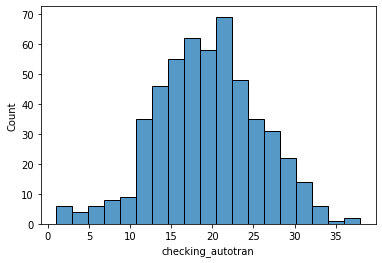

In [42]:
## feature exploration
sns.histplot(data= checking_tran_auto, x= 'checking_autotran');

In [43]:
## feature:  avg value of AUTO checking transaction (made by system, not customer)
checking_tran_auto_value= checking_tran[checking_tran.principal_amt ==0].groupby('cust_id').tran_amt.mean().reset_index()
checking_tran_auto_value.columns= ['cust_id', 'checking_autotran_value']
checking_tran_auto_value.sort_values('checking_autotran_value',ascending= False).head()
# auto transaction is small in value

,cust_id,checking_autotran_value
268,1363009,10.028667
420,1363308,7.165833
148,1362766,5.993684
364,1363215,5.890625
90,1362658,5.584667


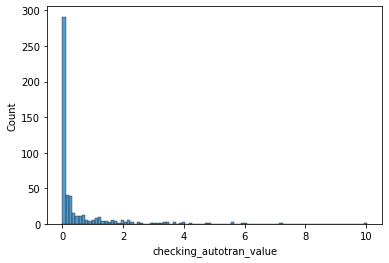

In [44]:
## feature exploration
sns.histplot(data= checking_tran_auto_value, x= 'checking_autotran_value');

### credit account
- feature: create account active

In [45]:
credit_account= pd.read_csv('mini-project-III/twm_credit_acct.csv',sep=";")
credit_account.head()

,cust_id,acct_nbr,credit_limit,credit_rating,account_active,acct_start_date,acct_end_date,starting_balance,ending_balance
0,1363160,4561143213631600,1000,0,Y,12.10.1988,NaN,657.46,286.69
1,1362487,4561143213624870,3000,0,Y,8.8.1995,NaN,0.00,1548.23
2,1362548,4561143213625480,6700,0,Y,11.11.1986,NaN,6965.25,68.68
3,1362752,4561143213627520,2400,0,N,9.10.1994,2.4.1995,2302.14,0.00
4,1363017,4561143213630170,1000,0,Y,8.2.1995,NaN,0.00,1000.00


In [46]:
credit_account.groupby('cust_id').acct_nbr.count().sort_values(ascending= False)
# no duplicated data for cust_id

cust_id
1362480    1
1363160    1
1363192    1
1363187    1
1363185    1
          ..
1362808    1
1362806    1
1362805    1
1362804    1
1363493    1
Name: acct_nbr, Length: 468, dtype: int64

In [47]:
credit_account[credit_account.credit_limit < credit_account.starting_balance].shape
# out of 468 credit users, only 23 users have starting balance > credit limit 
##>> small number, niche group, will not include this feature in model

(23, 9)

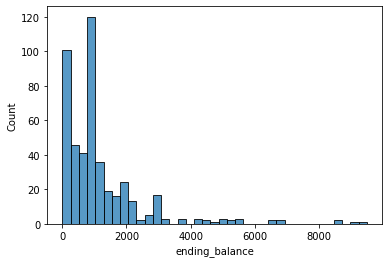

In [48]:
sns.histplot(data= credit_account, x= 'ending_balance');

In [49]:
#features
credit_account_features= credit_account[['cust_id','account_active','starting_balance','ending_balance']]
credit_account_features.columns=['cust_id', 'credit_account_active', 'credit_starting_balance', 'credit_ending_balance']

### credit transaction

In [50]:
credit_tran= pd.read_csv('mini-project-III/twm_credit_tran.csv',sep=";")
credit_tran.head(10)

,cust_id,tran_id,tran_amt,principal_amt,interest_amt,new_balance,tran_date,tran_time,channel,tran_code
0,1363088,46,-121.49,-121.49,0.00,-141.00,20.10.1995,101144,E,CG
1,1363306,32,-220.64,-220.64,0.00,-520.13,13.10.1995,83115,E,CG
2,1362959,10,0.00,0.00,0.00,-3900.00,26.2.1995,84129,K,IQ
3,1363429,13,-195.27,-195.27,0.00,-1739.74,3.1.1995,191815,E,CG
4,1363393,14,-37.32,-37.32,0.00,-198.98,4.7.1995,100811,E,CG
5,1363303,20,-180.00,-180.00,0.00,-180.00,8.8.1995,203528,A,CA
6,1363008,28,-102.28,-102.28,0.00,-740.23,13.8.1995,122055,E,CG
7,1362928,41,-25.14,-25.14,0.00,-843.42,26.6.1995,200337,E,CG
8,1363107,9,-72.06,-72.06,0.00,-72.06,14.4.1995,181619,E,CG
9,1362746,1,558.73,544.12,14.61,-492.99,7.1.1995,,M,PM


***understand dataset***

In [51]:
credit_tran.describe().round()
# interest have small value >> principal_amt ~ tran_amt >> we can focus on tran_amt feature 

,cust_id,tran_id,tran_amt,principal_amt,interest_amt,new_balance
count,20167.0,20167.0,20167.0,20167.0,20167.0,20167.0
mean,1362987.0,29.0,1.0,-1.0,2.0,-1130.0
std,293.0,22.0,456.0,452.0,8.0,1378.0
min,1362480.0,1.0,-1566.0,-1566.0,0.0,-17300.0
25%,1362730.0,12.0,-167.0,-167.0,0.0,-1411.0
50%,1362980.0,24.0,-68.0,-68.0,0.0,-766.0
75%,1363249.0,40.0,0.0,0.0,0.0,-334.0
max,1363492.0,155.0,17465.0,17300.0,165.0,0.0


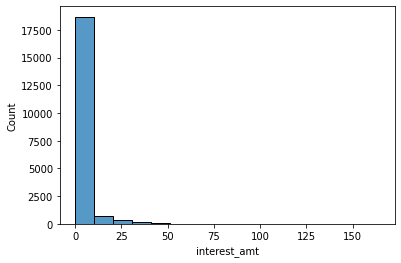

In [52]:
sns.histplot(data= credit_tran, x= 'interest_amt');

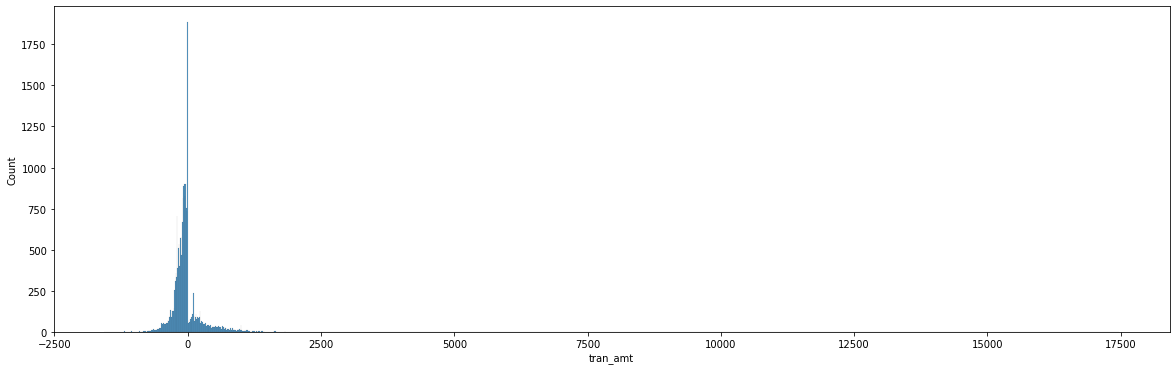

In [53]:
plt.figure(figsize=(20,6))
sns.histplot(data= credit_tran, x= 'tran_amt');
## tran_amt seems to have outlier with high value>> data scaling 

***features***

In [54]:
credit_tran.head(10)

,cust_id,tran_id,tran_amt,principal_amt,interest_amt,new_balance,tran_date,tran_time,channel,tran_code
0,1363088,46,-121.49,-121.49,0.00,-141.00,20.10.1995,101144,E,CG
1,1363306,32,-220.64,-220.64,0.00,-520.13,13.10.1995,83115,E,CG
2,1362959,10,0.00,0.00,0.00,-3900.00,26.2.1995,84129,K,IQ
3,1363429,13,-195.27,-195.27,0.00,-1739.74,3.1.1995,191815,E,CG
4,1363393,14,-37.32,-37.32,0.00,-198.98,4.7.1995,100811,E,CG
5,1363303,20,-180.00,-180.00,0.00,-180.00,8.8.1995,203528,A,CA
6,1363008,28,-102.28,-102.28,0.00,-740.23,13.8.1995,122055,E,CG
7,1362928,41,-25.14,-25.14,0.00,-843.42,26.6.1995,200337,E,CG
8,1363107,9,-72.06,-72.06,0.00,-72.06,14.4.1995,181619,E,CG
9,1362746,1,558.73,544.12,14.61,-492.99,7.1.1995,,M,PM


In [55]:
## feature: number of credit transaction (spending + deposit)
number_credit_tran= credit_tran.groupby('cust_id').tran_id.count().reset_index()
number_credit_tran.columns= ['cust_id','number_credit_tran']
number_credit_tran.head()

,cust_id,number_credit_tran
0,1362480,32
1,1362484,55
2,1362485,72
3,1362487,32
4,1362489,35


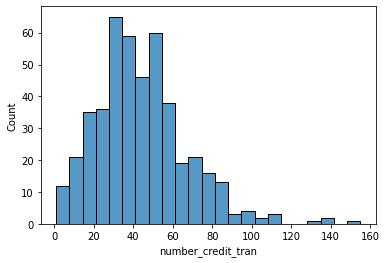

In [56]:
#feature exploration
sns.histplot(data= number_credit_tran, x= 'number_credit_tran');

In [57]:
## feature: number of negative transaction 
number_credit_negative= credit_tran[credit_tran.tran_amt<0].groupby('cust_id').tran_id.count().reset_index()
number_credit_negative.columns= ['cust_id','number_credit_negative']
number_credit_negative.head()

,cust_id,number_credit_negative
0,1362480,17
1,1362484,39
2,1362485,57
3,1362487,26
4,1362489,25


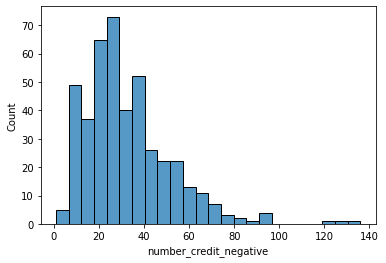

In [58]:
sns.histplot(data= number_credit_negative, x= 'number_credit_negative');

In [59]:
## feature: number of transaction equal 0
number_credit_0= credit_tran[credit_tran.tran_amt==0].groupby('cust_id').tran_id.count().reset_index()
number_credit_0.columns= ['cust_id','number_credit_0']
number_credit_0.head()

,cust_id,number_credit_0
0,1362480,3
1,1362484,4
2,1362485,3
3,1362487,2
4,1362489,1


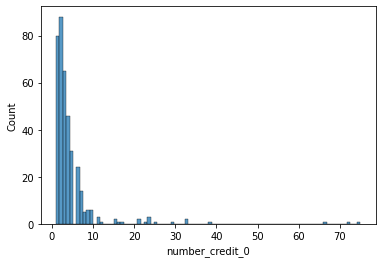

In [60]:
sns.histplot(data= number_credit_0, x= 'number_credit_0');

In [61]:
## feature: number of positive transaction 
number_credit_positive= credit_tran[credit_tran.tran_amt>0].groupby('cust_id').tran_id.count().reset_index()
number_credit_positive.columns= ['cust_id','number_credit_positive']
number_credit_positive.head()

,cust_id,number_credit_positive
0,1362480,12
1,1362484,12
2,1362485,12
3,1362487,4
4,1362489,9


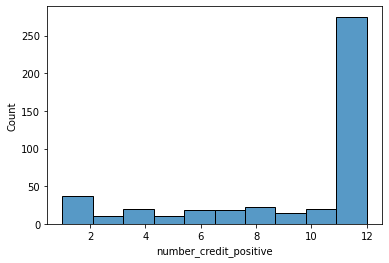

In [62]:
sns.histplot(data= number_credit_positive, x= 'number_credit_positive');

In [63]:
## feature: avg value credit tran
value_credit_tran= credit_tran.groupby('cust_id').tran_amt.mean().reset_index()
value_credit_tran.columns= ['cust_id','value_credit_tran']
value_credit_tran.sort_values('value_credit_tran', ascending= False).head()

,cust_id,value_credit_tran
343,1363237,8735.14
62,1362619,3905.04
297,1363146,2814.61
304,1363169,1749.60
292,1363133,1675.89


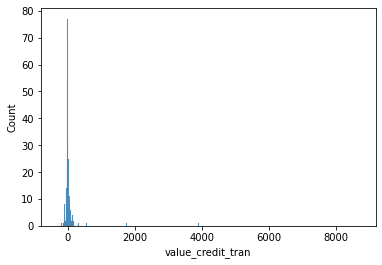

In [64]:
sns.histplot(data= value_credit_tran, x= 'value_credit_tran');

In [65]:
## feature: avg negative value credit tran (spending?!)
value_credit_spending= credit_tran[credit_tran.tran_amt <0].groupby('cust_id').tran_amt.mean().reset_index()
value_credit_spending.columns= ['cust_id','value_credit_spending']
value_credit_spending.sort_values('value_credit_spending', ascending= False).head()

,cust_id,value_credit_spending
283,1363159,-10.000000
49,1362598,-20.000000
162,1362845,-20.000000
20,1362542,-20.000000
82,1362672,-52.728462


In [66]:
value_credit_spending.value_credit_spending= abs(value_credit_spending.value_credit_spending)

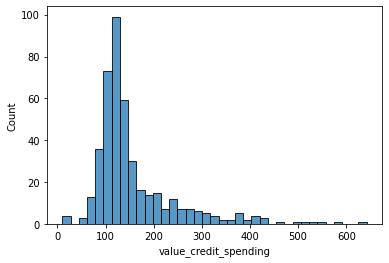

In [67]:
sns.histplot(data= value_credit_spending, x= 'value_credit_spending');

In [68]:
## feature: avg positive value credit tran (deposit?!)
value_credit_deposit= credit_tran[credit_tran.tran_amt >0].groupby('cust_id').tran_amt.mean().reset_index()
value_credit_deposit.columns= ['cust_id','value_credit_deposit']
value_credit_deposit.sort_values('value_credit_deposit', ascending= False).head()

,cust_id,value_credit_deposit
339,1363237,8735.140000
115,1362737,4595.880000
61,1362619,3905.040000
49,1362594,3092.602857
182,1362888,2981.025833


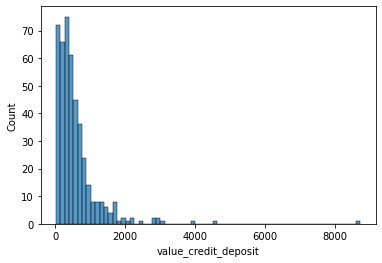

In [69]:
sns.histplot(data= value_credit_deposit, x= 'value_credit_deposit');

***create a dataframe of all features***

In [70]:
credit_tran_features= number_credit_tran.merge(number_credit_negative,how='outer').merge(number_credit_0,how='outer').merge(number_credit_positive,how='outer').merge(
value_credit_tran, how='outer').merge(value_credit_spending,how='outer').merge(value_credit_deposit,how='outer')

In [71]:
credit_tran_features.isna().sum()

cust_id                    0
number_credit_tran         0
number_credit_negative    22
number_credit_0           70
number_credit_positive     7
value_credit_tran          0
value_credit_spending     22
value_credit_deposit       7
dtype: int64

In [72]:
credit_tran_features.fillna(0,inplace= True)

### Saving account

In [73]:
saving_account= pd.read_csv('mini-project-III/twm_savings_acct.csv',sep=";")
saving_account.head()

,cust_id,acct_nbr,minimum_balance,acct_type,account_active,acct_start_date,acct_end_date,starting_balance,ending_balance
0,1363160,13631603,100,BS,Y,9.5.1988,NaN,113.04,122.54
1,1362487,13624873,500,MM,N,27.6.1994,25.8.1995,651.73,12.89
2,1362548,13625483,100,BS,Y,11.11.1986,NaN,250.24,254.02
3,1362752,13627523,100,BS,Y,20.2.1995,NaN,600.26,609.33
4,1363017,13630173,100,BS,N,27.4.1994,31.10.1995,2011.02,2901.35


***understand data***

In [74]:
saving_account.account_active.value_counts()

Y     375
N      46
Name: account_active, dtype: int64

In [75]:
saving_account.describe().round()

,cust_id,acct_nbr,minimum_balance,starting_balance,ending_balance
count,421.0,421.0,421.0,421.0,421.0
mean,1362987.0,13629876.0,194.0,874.0,1258.0
std,295.0,2952.0,170.0,1704.0,2055.0
min,1362480.0,13624803.0,100.0,100.0,3.0
25%,1362722.0,13627223.0,100.0,180.0,254.0
50%,1362980.0,13629803.0,100.0,311.0,619.0
75%,1363253.0,13632533.0,100.0,742.0,1536.0
max,1363495.0,13634953.0,500.0,17303.0,22433.0


In [76]:
saving_account_features= saving_account[['cust_id','account_active','starting_balance','ending_balance']]
saving_account_features.columns= ['cust_id', 'saving_account_active','saving_starting_balance','saving_ending_balance']

In [77]:
saving_account_features.head()

,cust_id,saving_account_active,saving_starting_balance,saving_ending_balance
0,1363160,Y,113.04,122.54
1,1362487,N,651.73,12.89
2,1362548,Y,250.24,254.02
3,1362752,Y,600.26,609.33
4,1363017,N,2011.02,2901.35


### Saving transaction

In [78]:
saving_tran= pd.read_csv('mini-project-III/twm_savings_tran.csv',sep=";")
saving_tran.head()

,cust_id,tran_id,tran_amt,principal_amt,interest_amt,new_balance,tran_date,tran_time,channel,tran_code
0,1363481,26,136.03,136.03,0.00,1521.57,26.10.1995,84111,A,DP
1,1362746,1,2.83,0.00,2.83,2265.90,31.1.1995,235959,,IN
2,1363251,11,13.56,0.00,13.56,5438.90,30.4.1995,235959,,IN
3,1362542,4,0.76,0.00,0.76,610.92,30.4.1995,235959,,IN
4,1363387,11,148.69,148.69,0.00,470.05,21.5.1995,144736,E,DP


***understanding data***

In [79]:
saving_tran.describe().round()

,cust_id,tran_id,tran_amt,principal_amt,interest_amt,new_balance
count,11189.0,11189.0,11189.0,11189.0,11189.0,11189.0
mean,1362988.0,16.0,14.0,14.0,1.0,1229.0
std,298.0,11.0,222.0,222.0,3.0,2257.0
min,1362480.0,1.0,-2496.0,-2496.0,0.0,0.0
25%,1362720.0,7.0,-1.0,-1.0,0.0,238.0
50%,1362978.0,14.0,0.0,0.0,0.0,562.0
75%,1363262.0,23.0,7.0,0.0,0.0,1247.0
max,1363495.0,62.0,4479.0,4479.0,45.0,26017.0


***feature***

In [80]:
## feature: number of saving transaction (spending + deposit)
number_saving_tran= saving_tran.groupby('cust_id').tran_id.count().reset_index()
number_saving_tran.columns= ['cust_id','number_saving_tran']
number_saving_tran.head()

,cust_id,number_saving_tran
0,1362480,26
1,1362484,33
2,1362486,25
3,1362487,19
4,1362489,22


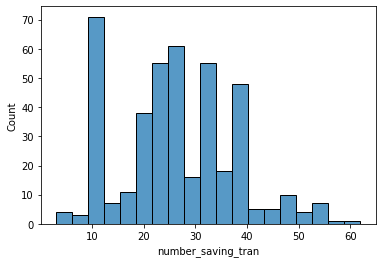

In [81]:
sns.histplot(data= number_saving_tran, x= 'number_saving_tran');

In [82]:
## feature: number of saving transaction (withdrawing)
number_withdrawing_saving= saving_tran[saving_tran.tran_amt<0].groupby('cust_id').tran_id.count().reset_index()
number_withdrawing_saving.columns= ['cust_id','number_withdrawing_saving']
number_withdrawing_saving.head()

,cust_id,number_withdrawing_saving
0,1362480,4
1,1362484,4
2,1362486,9
3,1362487,7
4,1362489,4


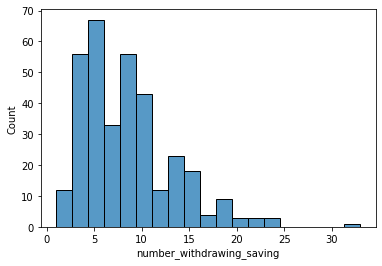

In [83]:
sns.histplot(data= number_withdrawing_saving, x= 'number_withdrawing_saving');

In [84]:
## feature: number of saving transaction (deposit)
number_deposit_saving= saving_tran[saving_tran.tran_amt>0].groupby('cust_id').tran_id.count().reset_index()
number_deposit_saving.columns= ['cust_id','number_deposit_saving']
number_deposit_saving.head()

,cust_id,number_deposit_saving
0,1362480,18
1,1362484,29
2,1362486,16
3,1362487,8
4,1362489,15


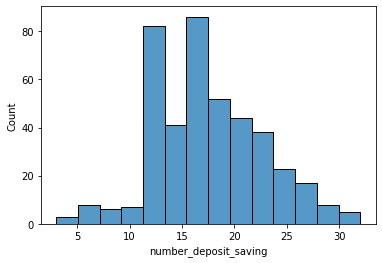

In [85]:
sns.histplot(data= number_deposit_saving, x= 'number_deposit_saving');

In [86]:
## feature: avg value of of saving transaction (spending + deposit)
value_saving_tran= saving_tran.groupby('cust_id').tran_amt.mean().reset_index()
value_saving_tran.columns= ['cust_id','value_saving_tran']
value_saving_tran.head()

,cust_id,value_saving_tran
0,1362480,18.550769
1,1362484,58.474545
2,1362486,-6.729600
3,1362487,-33.623158
4,1362489,-17.572273


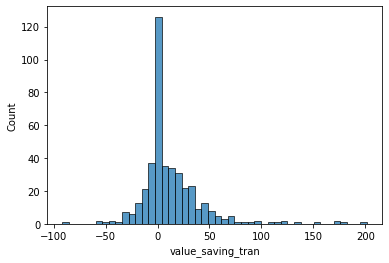

In [87]:
sns.histplot(data= value_saving_tran, x= 'value_saving_tran');

In [88]:
## feature: avg value of of withdrawing transaction 
value_withdrawing_saving= saving_tran[saving_tran.tran_amt<0].groupby('cust_id').tran_amt.mean().reset_index()
value_withdrawing_saving.columns= ['cust_id','value_withdrawing_saving']
value_withdrawing_saving.head()

,cust_id,value_withdrawing_saving
0,1362480,-358.210000
1,1362484,-257.342500
2,1362486,-85.782222
3,1362487,-109.025714
4,1362489,-315.612500


In [89]:
value_withdrawing_saving.value_withdrawing_saving= abs(value_withdrawing_saving.value_withdrawing_saving)

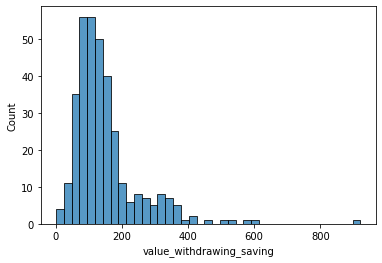

In [90]:
sns.histplot(data= value_withdrawing_saving, x= 'value_withdrawing_saving');

In [91]:
## feature: avg value of of deposit transaction 
value_deposit_saving= saving_tran[saving_tran.tran_amt>0].groupby('cust_id').tran_amt.mean().reset_index()
value_deposit_saving.columns= ['cust_id','value_deposit_saving']
value_deposit_saving.head()

,cust_id,value_deposit_saving
0,1362480,106.397778
1,1362484,102.035517
2,1362486,37.737500
3,1362487,15.542500
4,1362489,58.390667


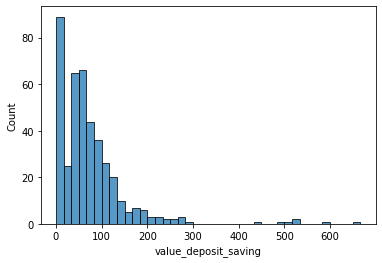

In [92]:
sns.histplot(data= value_deposit_saving, x= 'value_deposit_saving');

***combine features***

In [93]:
saving_tran_features= number_saving_tran.merge(number_withdrawing_saving,how='outer').merge(number_deposit_saving,how='outer').merge(
value_saving_tran,how='outer').merge(value_withdrawing_saving,how='outer').merge(value_deposit_saving,how='outer')

In [94]:
saving_tran_features.isna().sum()

cust_id                       0
number_saving_tran            0
number_withdrawing_saving    77
number_deposit_saving         0
value_saving_tran             0
value_withdrawing_saving     77
value_deposit_saving          0
dtype: int64

In [95]:
saving_tran_features.fillna(0, inplace= True)

### FINAL DATAFRAME

In [96]:
account_features.head()

,cust_id,no_of_account,no_active_account,no_nonactive_account
0,1362480,3,2.0,1.0
1,1362484,3,3.0,0.0
2,1362485,2,2.0,0.0
3,1362486,2,2.0,0.0
4,1362487,3,2.0,1.0


#### Checking

In [97]:
checking_account_features.head()
## for checking account, starting and ending balance may not be important as number of transaction

,cust_id,checking_account_active,checking_starting_balance,checking_ending_balance
0,1362548,Y,6004.34,569.65
1,1362487,Y,2781.07,1401.21
2,1363017,Y,2694.91,147.15
3,1362752,Y,487.69,3.76
4,1363282,Y,133.90,84.18


In [98]:
checking_tran_features.head()
# for checking trans: we only care about transaction made by customer, not the auto transaction by system (interest)

,cust_id,number_checking_tran,number_checking_spending,value_checking_tran,totalvalue_checking_tran,value_checking_spending,value_checking_deposit
0,1362480,83,69,-2.951687,-244.99,102.566957,488.009286
1,1362484,85,72,-29.637882,-2519.22,71.081667,199.896923
2,1362485,83,67,-1.979398,-164.29,77.378060,313.752500
3,1362486,10,9,-99.522000,-995.22,112.306667,15.540000
4,1362487,34,32,-41.457353,-1409.55,72.242500,451.105000


In [99]:
checking= checking_account_features.merge(checking_tran_features,how='outer')
checking.fillna(0, inplace= True)

In [100]:
checking= pd.get_dummies(data= checking, columns=['checking_account_active'],drop_first= True)
checking.head()

,cust_id,checking_starting_balance,checking_ending_balance,number_checking_tran,number_checking_spending,value_checking_tran,totalvalue_checking_tran,value_checking_spending,value_checking_deposit,checking_account_active_Y
0,1362548,6004.34,569.65,78.0,63.0,-70.046795,-5463.65,176.604127,377.494000,1
1,1362487,2781.07,1401.21,34.0,32.0,-41.457353,-1409.55,72.242500,451.105000,1
2,1363017,2694.91,147.15,78.0,62.0,-32.673462,-2548.53,101.653548,234.624375,1
3,1362752,487.69,3.76,75.0,67.0,-6.452400,-483.93,93.810746,725.173750,1
4,1363282,133.90,84.18,76.0,62.0,-0.654211,-49.72,62.663710,273.959286,1


In [101]:
checking['number_checking_deposit']=checking['number_checking_tran']-checking['number_checking_spending']

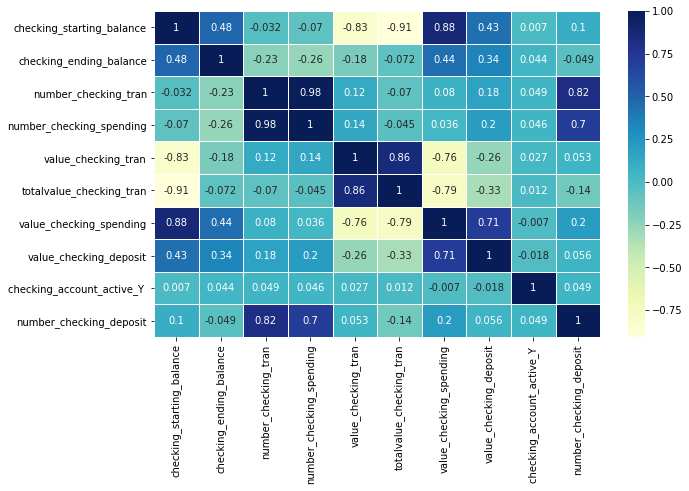

In [102]:
plt.figure(figsize=(10,6))
sns.heatmap(checking.iloc[:,1:].corr().round(3),
            linewidths=0.5,cbar=True,cmap='YlGnBu',annot=True)
plt.xticks(rotation=90)
plt.show()
# Checking_stating_balance vs checking_ending_balance: choose checking_ending_balance
# number_checking_tran= number_checking_spending+ number_checking_deposit: choose number_checking_spending,number_checking_deposit
# choose: value_checking_spending, value_checking_deposit

### Credit

In [103]:
credit_account_features.head()

,cust_id,credit_account_active,credit_starting_balance,credit_ending_balance
0,1363160,Y,657.46,286.69
1,1362487,Y,0.00,1548.23
2,1362548,Y,6965.25,68.68
3,1362752,N,2302.14,0.00
4,1363017,Y,0.00,1000.00


In [104]:
credit_tran_features.head()

,cust_id,number_credit_tran,number_credit_negative,number_credit_0,number_credit_positive,value_credit_tran,value_credit_spending,value_credit_deposit
0,1362480,32,17.0,3.0,12.0,60.895625,191.321176,433.426667
1,1362484,55,39.0,4.0,12.0,16.797636,116.890513,456.883333
2,1362485,72,57.0,3.0,12.0,-10.572639,117.459474,494.496667
3,1362487,32,26.0,2.0,4.0,-47.987187,121.323077,404.702500
4,1362489,35,25.0,1.0,9.0,48.405143,244.068400,866.210000


In [105]:
credit= credit_account_features.merge(credit_tran_features,how='outer')
credit.isna().sum()

cust_id                     0
credit_account_active       0
credit_starting_balance     0
credit_ending_balance       0
number_credit_tran         11
number_credit_negative     11
number_credit_0            11
number_credit_positive     11
value_credit_tran          11
value_credit_spending      11
value_credit_deposit       11
dtype: int64

In [106]:
credit.fillna(0, inplace= True)

In [107]:
credit= pd.get_dummies(data= credit, columns=['credit_account_active'],drop_first= True)

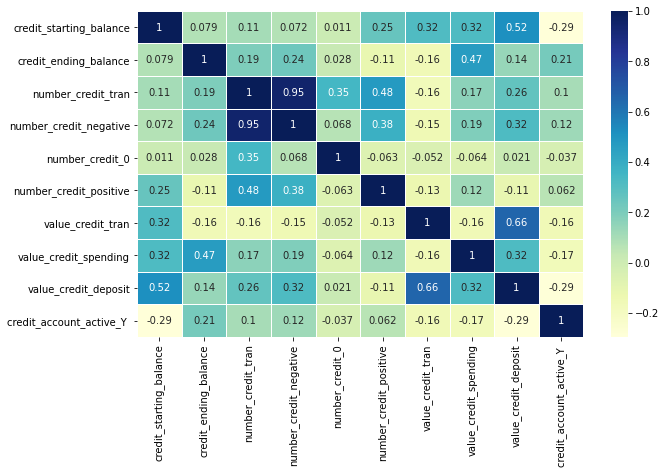

In [108]:
plt.figure(figsize=(10,6))
sns.heatmap(credit.iloc[:,1:].corr().round(3),
            linewidths=0.5,cbar=True,cmap='YlGnBu',annot=True)
plt.xticks(rotation=90)
plt.show()
# credit_stating_balance vs credit_ending_balance: keep both
# choose: number_credit_negative & number_credit_positive (number_credit_0 transaction is hard to understand >> ignore)
# choose: value_credit_spending & value_credit_deposit

### Saving

In [109]:
saving_account_features.head()

,cust_id,saving_account_active,saving_starting_balance,saving_ending_balance
0,1363160,Y,113.04,122.54
1,1362487,N,651.73,12.89
2,1362548,Y,250.24,254.02
3,1362752,Y,600.26,609.33
4,1363017,N,2011.02,2901.35


In [110]:
saving_tran_features.head()

,cust_id,number_saving_tran,number_withdrawing_saving,number_deposit_saving,value_saving_tran,value_withdrawing_saving,value_deposit_saving
0,1362480,26,4.0,18,18.550769,358.210000,106.397778
1,1362484,33,4.0,29,58.474545,257.342500,102.035517
2,1362486,25,9.0,16,-6.729600,85.782222,37.737500
3,1362487,19,7.0,8,-33.623158,109.025714,15.542500
4,1362489,22,4.0,15,-17.572273,315.612500,58.390667


In [111]:
saving= saving_account_features.merge(saving_tran_features,how='outer')
saving.isna().sum()

cust_id                      0
saving_account_active        0
saving_starting_balance      0
saving_ending_balance        0
number_saving_tran           1
number_withdrawing_saving    1
number_deposit_saving        1
value_saving_tran            1
value_withdrawing_saving     1
value_deposit_saving         1
dtype: int64

In [112]:
saving.fillna(0, inplace=True)

In [113]:
saving= pd.get_dummies(data= saving, columns=['saving_account_active'],drop_first= True)

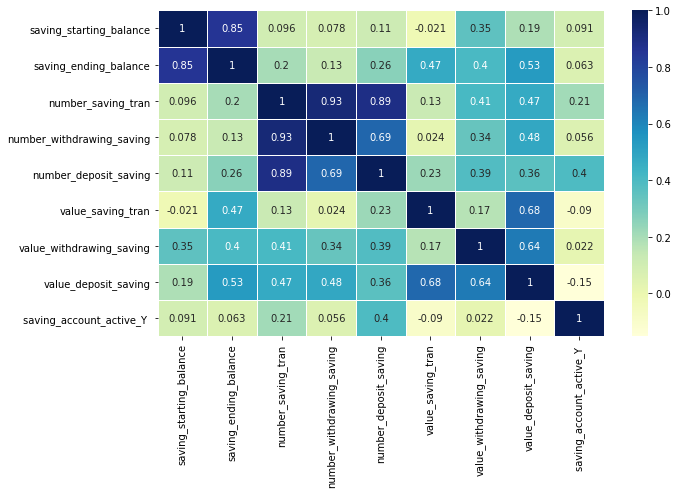

In [114]:
plt.figure(figsize=(10,6))
sns.heatmap(saving.iloc[:,1:].corr().round(3),
            linewidths=0.5,cbar=True,cmap='YlGnBu',annot=True)
plt.xticks(rotation=90)
plt.show()
# saving_starting_balance vs saving_ending_balance: choose saving_ending_balance
# choose number_deposit_saving & number_withdrawing_saving 
# choose value_withdrawing_saving & value_deposit_saving 

### Final data

In [115]:
behavior= account_features.merge(checking, how='outer').merge(credit,how='outer').merge(saving,how='outer')

In [116]:
behavior.isna().sum()

cust_id                         0
no_of_account                   0
no_active_account               0
no_nonactive_account            0
checking_starting_balance     145
checking_ending_balance       145
number_checking_tran          145
number_checking_spending      145
value_checking_tran           145
totalvalue_checking_tran      145
value_checking_spending       145
value_checking_deposit        145
checking_account_active_Y     145
number_checking_deposit       145
credit_starting_balance       197
credit_ending_balance         197
number_credit_tran            197
number_credit_negative        197
number_credit_0               197
number_credit_positive        197
value_credit_tran             197
value_credit_spending         197
value_credit_deposit          197
credit_account_active_Y       197
saving_starting_balance       244
saving_ending_balance         244
number_saving_tran            244
number_withdrawing_saving     244
number_deposit_saving         244
value_saving_t

In [117]:
print(account_features.shape)
print(checking.shape)
print(credit.shape)
print(saving.shape)
# na value is customer without specific account

(665, 4)
(520, 11)
(468, 11)
(421, 10)


In [118]:
behavior.fillna(0,inplace= True)

### Choose features

In [119]:
behavior.columns

Index(['cust_id', 'no_of_account', 'no_active_account', 'no_nonactive_account',
       'checking_starting_balance', 'checking_ending_balance',
       'number_checking_tran', 'number_checking_spending',
       'value_checking_tran', 'totalvalue_checking_tran',
       'value_checking_spending', 'value_checking_deposit',
       'checking_account_active_Y ', 'number_checking_deposit',
       'credit_starting_balance', 'credit_ending_balance',
       'number_credit_tran', 'number_credit_negative', 'number_credit_0',
       'number_credit_positive', 'value_credit_tran', 'value_credit_spending',
       'value_credit_deposit', 'credit_account_active_Y ',
       'saving_starting_balance', 'saving_ending_balance',
       'number_saving_tran', 'number_withdrawing_saving',
       'number_deposit_saving', 'value_saving_tran',
       'value_withdrawing_saving', 'value_deposit_saving',
       'saving_account_active_Y '],
      dtype='object')

### Scale data

In [120]:
robust_scaler= RobustScaler()

In [121]:
r_behavior= robust_scaler.fit_transform(behavior[['checking_starting_balance', 'checking_ending_balance',
       'number_checking_tran', 'number_checking_spending',
       'value_checking_tran', 'totalvalue_checking_tran',
       'value_checking_spending', 'value_checking_deposit',
       'number_checking_deposit',
       'credit_starting_balance', 'credit_ending_balance',
       'number_credit_tran', 'number_credit_negative', 'number_credit_0',
       'number_credit_positive', 'value_credit_tran', 'value_credit_spending',
       'value_credit_deposit', 
       'saving_starting_balance', 'saving_ending_balance',
       'number_saving_tran', 'number_withdrawing_saving',
       'number_deposit_saving', 'value_saving_tran',
       'value_withdrawing_saving', 'value_deposit_saving']])

In [122]:
r_behavior= pd.DataFrame(r_behavior,columns=['Rchecking_starting_balance', 'Rchecking_ending_balance',
       'Rnumber_checking_tran', 'Rnumber_checking_spending',
       'Rvalue_checking_tran', 'Rtotalvalue_checking_tran',
       'Rvalue_checking_spending', 'Rvalue_checking_deposit',
        'Rnumber_checking_deposit',
       'Rcredit_starting_balance', 'Rcredit_ending_balance',
       'Rnumber_credit_tran', 'Rnumber_credit_negative', 'Rnumber_credit_0',
       'Rnumber_credit_positive', 'Rvalue_credit_tran', 'Rvalue_credit_spending',
       'Rvalue_credit_deposit', 
       'Rsaving_starting_balance', 'Rsaving_ending_balance',
       'Rnumber_saving_tran', 'Rnumber_withdrawing_saving',
       'Rnumber_deposit_saving', 'Rvalue_saving_tran',
       'Rvalue_withdrawing_saving', 'Rvalue_deposit_saving'])
r_behavior.head()

,Rchecking_starting_balance,Rchecking_ending_balance,Rnumber_checking_tran,Rnumber_checking_spending,Rvalue_checking_tran,Rtotalvalue_checking_tran,Rvalue_checking_spending,Rvalue_checking_deposit,Rnumber_checking_deposit,Rcredit_starting_balance,...,Rvalue_credit_spending,Rvalue_credit_deposit,Rsaving_starting_balance,Rsaving_ending_balance,Rnumber_saving_tran,Rnumber_withdrawing_saving,Rnumber_deposit_saving,Rvalue_saving_tran,Rvalue_withdrawing_saving,Rvalue_deposit_saving
0,-0.007506,-0.056324,0.156250,0.211538,-0.013091,-0.026765,0.508112,1.401670,0.071429,1.586052,...,0.592773,0.394541,1.082464,1.099916,0.357143,0.250,0.333333,1.760547,2.488475,1.278242
1,0.881654,-0.040988,0.187500,0.269231,-0.842747,-1.042772,0.110607,-0.122186,0.000000,1.261796,...,0.064913,0.438225,0.055010,2.142027,0.607143,0.250,0.944444,5.549483,1.696508,1.216869
2,-0.055077,-0.131320,0.156250,0.173077,0.017137,0.009288,0.190099,0.480008,0.214286,0.278630,...,0.068948,0.508274,-0.335573,-0.225277,-0.571429,-0.250,-0.666667,0.000000,-0.324030,-0.218667
3,1.520356,5.790729,-0.984375,-0.942308,-3.015397,-0.361928,0.631077,-1.097268,-0.857143,0.000000,...,-0.764071,-0.412649,0.234939,-0.095610,0.321429,0.875,0.222222,-0.638668,0.349493,0.312261
4,0.946973,2.326342,-0.609375,-0.500000,-1.210206,-0.547029,0.125262,1.206480,-0.785714,0.000000,...,0.096349,0.341047,0.971442,-0.210899,0.107143,0.625,-0.222222,-3.190981,0.531991,0.000000


In [123]:
### concat scaled data into original df
behavior_scale= pd.concat([behavior,r_behavior],axis=1)
behavior_scale.columns

Index(['cust_id', 'no_of_account', 'no_active_account', 'no_nonactive_account',
       'checking_starting_balance', 'checking_ending_balance',
       'number_checking_tran', 'number_checking_spending',
       'value_checking_tran', 'totalvalue_checking_tran',
       'value_checking_spending', 'value_checking_deposit',
       'checking_account_active_Y ', 'number_checking_deposit',
       'credit_starting_balance', 'credit_ending_balance',
       'number_credit_tran', 'number_credit_negative', 'number_credit_0',
       'number_credit_positive', 'value_credit_tran', 'value_credit_spending',
       'value_credit_deposit', 'credit_account_active_Y ',
       'saving_starting_balance', 'saving_ending_balance',
       'number_saving_tran', 'number_withdrawing_saving',
       'number_deposit_saving', 'value_saving_tran',
       'value_withdrawing_saving', 'value_deposit_saving',
       'saving_account_active_Y ', 'Rchecking_starting_balance',
       'Rchecking_ending_balance', 'Rnumber_checkin

In [124]:
def kmean(number_of_clusters, dataframe,list_feature):
    km = KMeans(n_clusters=number_of_clusters, n_init=20,random_state=0)
    return km.fit_predict(dataframe[list_feature])

In [125]:
features2= [
            'Rnumber_checking_spending', 
       'Rvalue_checking_spending', 
            'Rnumber_credit_negative', 
       'Rvalue_credit_spending', 
       'Rnumber_deposit_saving', 
       'Rvalue_deposit_saving']
## original data
# 'cust_id','no_of_account',
# 'checking_starting_balance', 'checking_ending_balance',
# 'number_checking_tran', 'number_checking_spending','number_checking_deposit',
#'value_checking_tran', 'totalvalue_checking_tran',
#'value_checking_spending', 'value_checking_deposit',
# 'credit_starting_balance', 'credit_ending_balance',
# 'number_credit_tran', 'number_credit_negative', 'number_credit_0',
# 'number_credit_positive', 'value_credit_tran', 'value_credit_spending','value_credit_deposit',
# 'saving_starting_balance', 'saving_ending_balance', 
# 'number_saving_tran', 'number_withdrawing_saving',
# 'number_deposit_saving', 'value_saving_tran',
# 'value_withdrawing_saving', 'value_deposit_saving',      
## scaled data but not use in model
#'Rchecking_starting_balance','Rnumber_checking_tran', 'Rtotalvalue_checking_tran','Rvalue_checking_tran',
# 'Rnumber_credit_tran','Rnumber_credit_0','Rvalue_credit_tran',
# 'Rsaving_starting_balance', 'Rnumber_saving_tran','Rvalue_saving_tran'

In [126]:
#4 clusters
behavior_scale['Kcluster_4']= kmean(4, behavior_scale,features2)
behavior_scale['Kcluster_4'].value_counts()

2    288
1    273
0     79
3     25
Name: Kcluster_4, dtype: int64

In [127]:
# checking
behavior_scale.groupby('Kcluster_4')[['no_of_account','number_checking_tran','checking_starting_balance', 'checking_ending_balance',
                                    'number_checking_spending','value_checking_spending'
                                                                         ]].mean().round()
# 0 & 3: high spending volumne and value
# 1: high spending volume but average value
# 2: not active, low balance, low spending volumne and value

,no_of_account,number_checking_tran,checking_starting_balance,checking_ending_balance,number_checking_spending,value_checking_spending
Kcluster_4,,,,,,
0,2.0,69.0,5095.0,1335.0,55.0,216.0
1,3.0,66.0,1350.0,424.0,54.0,70.0
2,2.0,38.0,792.0,305.0,31.0,41.0
3,3.0,72.0,5190.0,1290.0,59.0,219.0


In [128]:
# credit
behavior_scale.groupby('Kcluster_4')[[
                                     'credit_starting_balance', 'credit_ending_balance',
                                    'number_credit_negative',
                                    'value_credit_spending'
                                         ]].mean().round()
# 0& 3: average credit spending volumn but very high value
# 1: high credit spending volumne but average value 
# 2: low spending capacity
# in lign with checking account situation

,credit_starting_balance,credit_ending_balance,number_credit_negative,value_credit_spending
Kcluster_4,,,,
0,1887.0,1266.0,19.0,181.0
1,858.0,1251.0,39.0,144.0
2,336.0,236.0,5.0,35.0
3,1819.0,1809.0,21.0,206.0


In [129]:
# saving
behavior_scale.groupby('Kcluster_4')[[
                                     'saving_starting_balance', 'saving_ending_balance', 
                                   'number_deposit_saving', 'value_deposit_saving'      
                                         ]].mean().round()
# 0& 3: they are 2 groups of active spending (high volumne & value) but are different in saving situation:
# 0: low saving
# 3: high spending power with high saving deposit and balance
# 1: while this group have low starting saving balance, average deposit value is highest among 4 group which result in high ending balance

,saving_starting_balance,saving_ending_balance,number_deposit_saving,value_deposit_saving
Kcluster_4,,,,
0,752.0,772.0,5.0,22.0
1,492.0,713.0,13.0,50.0
2,408.0,524.0,10.0,27.0
3,2268.0,4925.0,20.0,313.0


In [130]:
# conclusion: 
# 0- 79 cus: spending group with low intention of saving (low number of deposit into saving account) >> spending promotions
# 3- 25 cus: spending group with strong financial power >> most potentials group
# 1- 273 cus: saving group (make many transaction but small value while putting more money into saving account) >> promotions emphasize on value saving
# 2 -288 cus: low spending capacity and saving power >>  may not be potential ?!

### PCA 

In [132]:
pca= sklearn.decomposition.PCA()

In [134]:
pca_result= pca.fit_transform(behavior_scale[['Rnumber_checking_spending', 
       'Rvalue_checking_spending', 
            'Rnumber_credit_negative', 
       'Rvalue_credit_spending', 
       'Rnumber_deposit_saving', 
       'Rvalue_deposit_saving']])

In [135]:
pca.explained_variance_ratio_ 

array([0.39883705, 0.27941262, 0.16796417, 0.07264543, 0.04350017,
       0.03764056])

In [138]:
fig = px.scatter(pca_result, x=0, y=1, color=behavior_scale['Kcluster_4'],
                labels={'0': 'PC 1', '1': 'PC 2'})
fig.show()

### Check loading of 2 PC vs original feature

In [142]:
df_comp = pd.DataFrame(pca.components_.round(1),columns=['Rnumber_checking_spending','Rvalue_checking_spending', 
            'Rnumber_credit_negative', 
       'Rvalue_credit_spending', 
       'Rnumber_deposit_saving', 
       'Rvalue_deposit_saving'], 
                       index=['pc1','pc2','pc3','pc4','pc5','pc6'])

<AxesSubplot:>

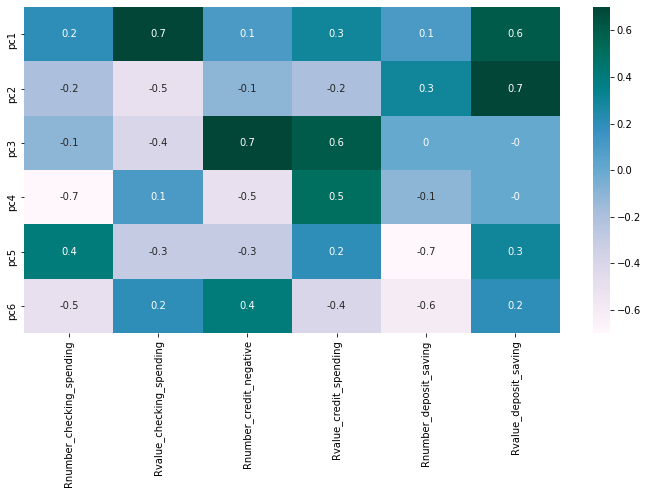

In [143]:
plt.figure(figsize=(12,6)) # visualize relationship of each new component vs. original features
sns.heatmap(df_comp,cmap='PuBuGn',annot=True)
# 2 original features that have high impact on clusters are:  avg value of checking spending & avg value of deposit saving 

### Hierachical Model

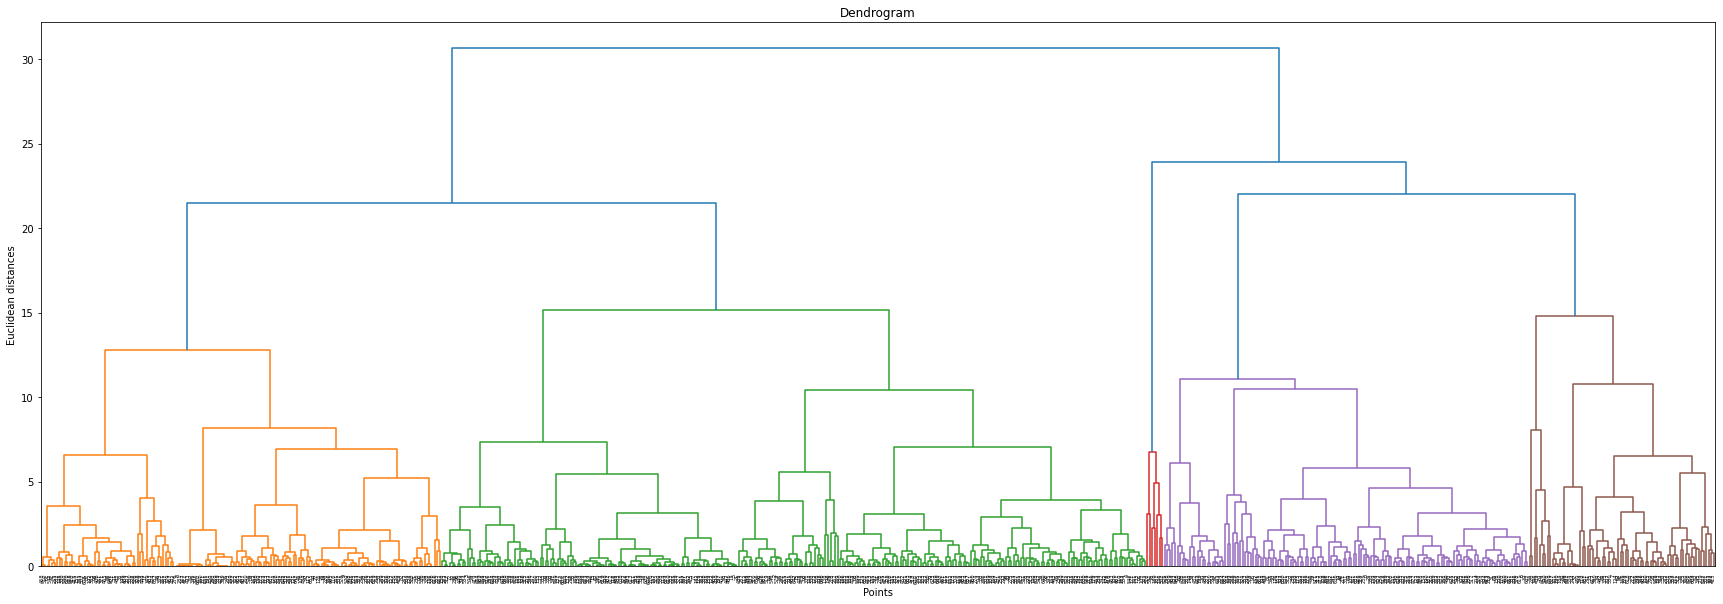

In [144]:
plt.figure(figsize=(30,10))
sch.dendrogram(sch.linkage(behavior_scale[['Rnumber_checking_spending', 
       'Rvalue_checking_spending', 
            'Rnumber_credit_negative', 
       'Rvalue_credit_spending', 
       'Rnumber_deposit_saving', 
       'Rvalue_deposit_saving']], method='ward'))
plt.title("Dendrogram")
plt.ylabel("Euclidean distances")
plt.xlabel('Points');
#{'ward', 'complete', 'average', 'single'}

In [145]:
ac = AgglomerativeClustering(affinity='euclidean',linkage='ward', n_clusters = 4)
behavior_scale['Hcluster_4']= ac.fit_predict(behavior_scale[['Rnumber_checking_spending', 
       'Rvalue_checking_spending', 
            'Rnumber_credit_negative', 
       'Rvalue_credit_spending', 
       'Rnumber_deposit_saving', 
       'Rvalue_deposit_saving']])
behavior_scale['Hcluster_4'].value_counts()

0    439
3    145
1     74
2      7
Name: Hcluster_4, dtype: int64